In [1]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from pylab import *
import matplotlib.pyplot as plt
from keras import models
from keras.models import load_model, Sequential
from keras import layers
import itertools
from sklearn.metrics import confusion_matrix
from PIL import Image
import pandas as pd
from keras.applications.vgg19 import VGG19
from keras.callbacks import LearningRateScheduler
import os

In [2]:
def Read_image(path):
    image = Image.open(path).convert('RGB')
    return image

In [3]:
def step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=10):
        def schedule(epoch):
            return initial_lr * (decay_factor ** np.floor(epoch / step_size))
        return LearningRateScheduler(schedule)

In [4]:
image_size = (100, 100)
def prepare_image(image_path):
    return np.array(Read_image(image_path).resize(image_size)).flatten() / 255.0
X = [] # ELA converted images
Y = [] # 0 for fake, 1 for real

In [5]:
import random
path = 'C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Au/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(1)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

random.shuffle(X)
X = X[:2100]
Y = Y[:2100]
print(len(X), len(Y))

Processing 500 images
Processing 1000 images
Processing 1500 images
Processing 2000 images
Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
Processing 4500 images
Processing 5000 images
Processing 5500 images
Processing 6000 images
Processing 6500 images
Processing 7000 images
2100 2100


In [6]:
path = 'C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Tp/'
for dirname, _, filenames in os.walk(path):
    for filename in filenames:
        if filename.endswith('jpg') or filename.endswith('png'):
            full_path = os.path.join(dirname, filename)
            X.append(prepare_image(full_path))
            Y.append(0)
            if len(Y) % 500 == 0:
                print(f'Processing {len(Y)} images')

print(len(X), len(Y))

Processing 2500 images
Processing 3000 images
Processing 3500 images
Processing 4000 images
4164 4164


In [7]:
import numpy as np
X = np.array(X)
Y = to_categorical(Y, 2)
X = X.reshape(-1, 100, 100, 3)

In [8]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size = 0.2, random_state=5)

# Load the VGG model
vgg_conv = VGG19(weights='imagenet', include_top=False, input_shape=(100, 100, 3))

In [9]:
def build_model():
    model = models.Sequential()
    for layer in vgg_conv.layers[:-5]:
        layer.trainable = False

    model.add(vgg_conv)
    model.add(layers.Flatten())
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.50))
    model.add(layers.Dense(1024, activation='relu'))
    model.add(layers.Dropout(0.50))
    model.add(layers.Dense(2, activation='softmax'))
    return model

In [10]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 3, 3, 512)         20024384  
_________________________________________________________________
flatten (Flatten)            (None, 4608)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              4719616   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 2

In [11]:
from tensorflow.keras import optimizers
optimizer = optimizers.Adam(learning_rate=1e-3, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy',optimizer=optimizer,metrics=['accuracy'])

In [12]:
from tensorflow import keras
from keras.applications.vgg19 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

epochs = 30
batch_size = 32

lr_sched = step_decay_schedule(initial_lr=1e-4, decay_factor=0.75, step_size=2)

training_datagen = ImageDataGenerator(rescale=1./255,   # all pixel values will be between 0 an 1
                                    shear_range=0.2, 
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    preprocessing_function=preprocess_input)

validation_datagen = ImageDataGenerator(rescale = 1./255, preprocessing_function=preprocess_input)

history = model.fit(X_train, Y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, Y_val),verbose=2,callbacks=[lr_sched])

Epoch 1/30
105/105 - 614s - loss: 0.7112 - accuracy: 0.5251 - val_loss: 0.6634 - val_accuracy: 0.5990
Epoch 2/30
105/105 - 463s - loss: 0.6632 - accuracy: 0.5953 - val_loss: 0.6319 - val_accuracy: 0.6495
Epoch 3/30
105/105 - 604s - loss: 0.5807 - accuracy: 0.6971 - val_loss: 0.5979 - val_accuracy: 0.6807
Epoch 4/30
105/105 - 687s - loss: 0.4810 - accuracy: 0.7709 - val_loss: 0.5959 - val_accuracy: 0.6855
Epoch 5/30
105/105 - 532s - loss: 0.3658 - accuracy: 0.8397 - val_loss: 0.6767 - val_accuracy: 0.7107
Epoch 6/30
105/105 - 479s - loss: 0.2562 - accuracy: 0.8991 - val_loss: 0.7848 - val_accuracy: 0.7023
Epoch 7/30
105/105 - 467s - loss: 0.1904 - accuracy: 0.9295 - val_loss: 0.9365 - val_accuracy: 0.6951
Epoch 8/30
105/105 - 434s - loss: 0.1429 - accuracy: 0.9448 - val_loss: 1.0510 - val_accuracy: 0.6879
Epoch 9/30
105/105 - 436s - loss: 0.1251 - accuracy: 0.9508 - val_loss: 1.0139 - val_accuracy: 0.6867
Epoch 10/30
105/105 - 432s - loss: 0.1065 - accuracy: 0.9535 - val_loss: 1.1655 - 

In [17]:
model.save('VGG19.h5')

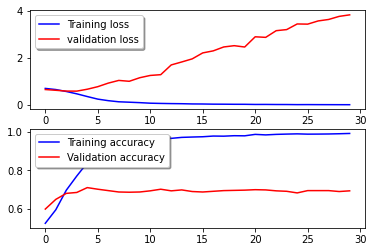

In [19]:
# Plot the loss and accuracy curves for training and validation 
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [21]:
# Load the saved model from disk
model = load_model('VGG19.h5')

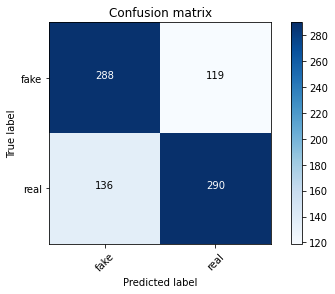

In [22]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, ['fake','real'])

In [23]:
from sklearn import metrics
score = metrics.precision_score(Y_true, Y_pred_classes, average= "weighted")
print("Precision score: {}".format(score))
score = metrics.recall_score(Y_true, Y_pred_classes, average= "weighted")
print("Recall score: {}".format(score))
score_lr1 = metrics.f1_score(Y_true, Y_pred_classes, average= "weighted")
print("F1 score: {}".format(score_lr1))

Precision score: 0.6944857381989563
Recall score: 0.6938775510204082
F1 score: 0.6938925508593804


In [24]:
class_names = ['fake', 'real']

In [25]:
fake_image = os.listdir('C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Tp/')
correct = 0
total = 0
for file_name in fake_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        fake_image_path = os.path.join('C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Tp/', file_name)
        image = prepare_image(fake_image_path)
        image = image.reshape(-1, 100, 100, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total += 1
        if y_pred_class == 0:
            correct += 1
#             print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [26]:
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 2064, Correct: 1940, Acc: 93.9922480620155


In [27]:
real_image = os.listdir('C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Au/')
correct_r = 0
total_r = 0
for file_name in real_image:
    if file_name.endswith('jpg') or filename.endswith('png'):
        real_image_path = os.path.join('C:/Users/prati/ImageForgeryDetection/Dataset/CASIA2/Au/', file_name)
        image = prepare_image(real_image_path)
        image = image.reshape(-1, 100, 100, 3)
        y_pred = model.predict(image)
        y_pred_class = np.argmax(y_pred, axis = 1)[0]
        total_r += 1
        if y_pred_class == 1:
            correct_r += 1
     #        print(f'Class: {class_names[y_pred_class]} Confidence: {np.amax(y_pred) * 100:0.2f}')

In [28]:
correct += correct_r
total += total_r
print(f'Total: {total_r}, Correct: {correct_r}, Acc: {correct_r / total_r * 100.0}')
print(f'Total: {total}, Correct: {correct}, Acc: {correct / total * 100.0}')

Total: 7354, Correct: 5680, Acc: 77.2368778895839
Total: 9418, Correct: 7620, Acc: 80.90889785517095
